# Cognition and Computation Project

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Restricted Boltzmann Machine

In [2]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, k=1):
        super(RBM, self).__init__()

        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.k = k

    def sample_h(self, v):
        prob_h = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return prob_h, torch.bernoulli(prob_h)

    def sample_v(self, h):
        prob_v = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return prob_v, torch.bernoulli(prob_v)

    def free_energy(self, v):
        vbias_term = v @ self.v_bias
        hidden_term = torch.sum(F.softplus(v @ self.W.t() + self.h_bias), dim=1)
        return -vbias_term - hidden_term

    @torch.no_grad()
    def gibbs_k(self, v):
        prob_h, h = self.sample_h(v)
        prob_v = None
        for _ in range(self.k):
            prob_v, v = self.sample_v(h)
            prob_h, h = self.sample_h(v)
        return prob_v, v

    def fit(self, dataset, learning_rate=0.001, epochs=5, batch_size=32, device=None):
        self.to(device)
        dataset = dataset.to(device)
        n = len(dataset)

        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        recon_loss_history = []
        for epoch in range(epochs):
            epoch_recon_loss_history = []

            shuffle = torch.randperm(n, device=device)

            for start in range(0, n, batch_size):
                i  = shuffle[start:start+batch_size]
                v0 = dataset[i]

                prob_v, v = self.gibbs_k(v0)

                loss = (self.free_energy(v0) - self.free_energy(v)).mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                recon_loss = F.mse_loss(v0, prob_v).item()
                epoch_recon_loss_history.append(recon_loss)

            epoch_recon_loss = float(np.mean(epoch_recon_loss_history))
            recon_loss_history.append(epoch_recon_loss)

            if epoch % 10 == 0 or epoch == epochs - 1:
              print(f"Epoch {epoch+1}/{epochs}, MSE: {epoch_recon_loss:.6f}")

        return recon_loss_history

## Deep Belief Network

In [3]:
class DBN(nn.Module):
  def __init__(self, n_visible, n_hidden=[], k=1):
    super(DBN, self).__init__()

    self.n_visible = n_visible
    self.n_hidden = n_hidden
    self.k = k

    sizes = [n_visible] + self.n_hidden
    self.rbms = nn.ModuleList([
        RBM(n_visible=sizes[i], n_hidden=sizes[i + 1], k=k)
        for i in range(len(sizes) - 1)
    ])

    @torch.no_grad()
    def encode(self, v, return_samples=False):
        """Forward pass"""
        x = v
        for rbm in self.rbms:
            prob_h, h = rbm.sample_h(x)
            x = h if return_samples else prob_h
        return x

    @torch.no_grad()
    def decode(self, h, return_samples=False):
        """Backward (generative) pass"""
        x = h
        for rbm in reversed(self.rbms):
            prob_v, v = rbm.sample_v(x)
            x = v if return_samples else prob_v
        return x

    @torch.no_grad()
    def reconstruct(self, v, return_samples=False):
        """Encode and then decode"""
        h = self.encode(v, return_samples=return_samples)
        v_rec = self.decode(h, return_samples=return_samples)
        return v_rec

    def pretrain(
        self,
        dataset,
        learning_rate=0.001,
        epochs=5,
        batch_size=32,
        device=None,
        use_samples_between_layers=False,
    ):
        x = dataset.to(device)

        histories = []
        for layer_idx, rbm in enumerate(self.rbms):
            print(f"Pretraining layer {layer_idx+1}/{len(self.rbms)}: ({rbm.W.shape[0]} -> {rbm.W.shape[1]})")

            hist = rbm.fit(
                dataset=x,
                learning_rate=learning_rate,
                epochs=epochs,
                batch_size=batch_size,
                device=device
            )
            histories.append(hist)

            with torch.no_grad():
                prob_h, h = rbm.sample_h(x)
                x = h if use_samples_between_layers else prob_h

        return histories

    def get_encoder(self):
        """
        Creates a feed-forward encoder network initialized from RBM params:
        Linear(W, h_bias) + Sigmoid per layer.

        Useful for supervised fine-tuning (attach classifier head).
        """
        layers = []
        for rbm in self.rbms:
            lin = nn.Linear(rbm.W.shape[1], rbm.W.shape[0], bias=True)
            # RBM.W is (hidden, visible) -> matches Linear(out, in)
            lin.weight.data.copy_(rbm.W.data)
            lin.bias.data.copy_(rbm.h_bias.data)
            layers += [lin, nn.Sigmoid()]
        return nn.Sequential(*layers)

## Utils functions

In [4]:
def show_img(img, digit=None):
  if digit is not None:
    print(f'The image shows the digit: {digit}' )
  img = img.cpu()
  plt.imshow(img, cmap = 'gray')
  plt.show()

def compare_imgs(imgs, digit):
  print(f'The images show the digit: {digit}' )
  n_imgs = len(imgs)
  for i, img in enumerate(imgs):
    img = img.cpu()
    plt.subplot(1, n_imgs, i+1)
    plt.imshow(img, cmap = 'gray')
  plt.show()

## Training on MNIST

In [5]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f'Using device: {device_name}')

Using device: cuda


In [6]:
mnist_train_ds = torchvision.datasets.MNIST(root='mnist', train=True, download=True)
mnist_test_ds = torchvision.datasets.MNIST(root='mnist', train=False, download=True)

mnist_train_ds.data = mnist_train_ds.data / 255
mnist_test_ds.data = mnist_test_ds.data / 255

mnist_train_ds.data = mnist_train_ds.data.to(device)
mnist_test_ds.data = mnist_test_ds.data.to(device)
mnist_train_ds.targets = mnist_train_ds.targets.to(device)
mnist_test_ds.targets = mnist_test_ds.targets.to(device)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]


The image shows the digit: 5


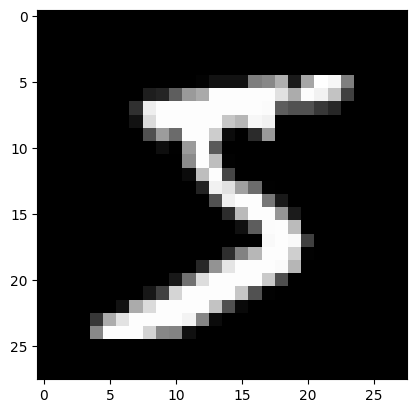

In [7]:
idx = 0
img = mnist_train_ds.data[idx]
digit = mnist_train_ds.targets[idx]

show_img(img, digit)

In [8]:
print(f'Training dataset shape: {mnist_train_ds.data.shape}')
print(f'Test dataset shape: {mnist_test_ds.data.shape}')

Training dataset shape: torch.Size([60000, 28, 28])
Test dataset shape: torch.Size([10000, 28, 28])


In [14]:
mnist_img_shape = (28, 28)
n_visible = mnist_img_shape[0] * mnist_img_shape[1]
n_hidden = 128

In [9]:
train_ds_size = mnist_train_ds.data.shape[0]
train_data = mnist_train_ds.data.reshape(train_ds_size, n_visible)

# Initialize RBM
rbm = RBM(
    n_visible=n_visible,
    n_hidden=n_hidden,
    k=1
)

# RBM training
loss_history = rbm.fit(
    dataset=train_data,
    learning_rate=0.001,
    epochs=40,
    batch_size=32,
    device=device
)

Epoch 1/40, MSE: 0.045015
Epoch 11/40, MSE: 0.014673
Epoch 21/40, MSE: 0.013049
Epoch 31/40, MSE: 0.012511
Epoch 40/40, MSE: 0.012253


The images show the digit: 0


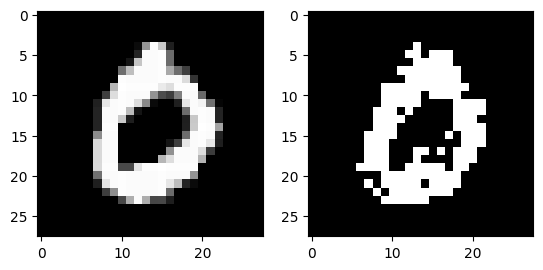

In [18]:
test_idx = 3
test_img = mnist_test_ds.data[test_idx]
test_digit = mnist_test_ds.targets[test_idx]

_prob_h, _h = rbm.sample_h(test_img.reshape(1, n_visible))
_prob_v, _v = rbm.sample_v(_h)

reconstruct_img = _v.reshape(mnist_img_shape).detach()

compare_imgs([test_img, reconstruct_img], test_digit)

In [19]:
# Saving weights to file
weights_file_name = 'rbm_weights.pth'
torch.save(rbm.state_dict(), weights_file_name)
print(f'RBM model weights saved to "{weights_file_name}"')

# Loading weights from file
new_rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, k=1)
new_rbm.load_state_dict(torch.load(weights_file_name))
new_rbm.to(device)
print(f'RBM model weights loaded from "{weights_file_name}"')

RBM model weights saved to "rbm_weights.pth"
RBM model weights loaded from "rbm_weights.pth"
